## LSTM state encoder [TEST]

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [27]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')
# ---
frame_size = 10
batch_size = 25
# --- 

tqdm.pandas()

In [3]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_embeddings_key_dict = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
movies_embeddings_tensor, key_to_id, id_to_key = recnn.data.make_items_tensor(movie_embeddings_key_dict)
# download ml20m dataset yourself
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = recnn.data.prepare_dataset(ratings, key_to_id, frame_size)

del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

Done!


In [28]:
def run_tests():
    test_batch = next(iter(test_dataloader))
    batch = [state, action, reward, next_state, torch.tensor(0)]
    loss = recnn.learning.ddpg_update(batch, params, nets, optimizer,
                                       cuda, debugger, step=step)
    losses = ddpg_update(test_batch, params, learn=False, step=step)
    return losses

In [29]:
# === ddpg settings ===

params = {
    'gamma'      : 0.99,
    'min_value'  : -10,
    'max_value'  : 10,
    'policy_step': 3,
    'soft_tau'   : 0.001,
    
    'policy_lr'  : 1e-5,
    'value_lr'   : 1e-5,
    'actor_weight_init': 3e-1,
    'critic_weight_init': 6e-1,
}

# === end ===

In [30]:
value_net  = recnn.models.Critic(256, 128, 256, params['critic_weight_init']).to(cuda)
policy_net = recnn.models.Actor(256, 128, 256, params['actor_weight_init']).to(cuda)

target_value_net = recnn.models.Critic(256, 128, 256).to(cuda)
target_policy_net = recnn.models.Actor(256, 128, 256).to(cuda)

state_encoder = nn.LSTM(129, 256, batch_first=True).to(cuda)

target_policy_net.eval()
target_value_net.eval()


recnn.learning.soft_update(value_net, target_value_net, soft_tau=1.0)
recnn.learning.soft_update(policy_net, target_policy_net, soft_tau=1.0)

# optim.Adam can be replaced with RAdam
pm = list(policy_net.parameters()) + list(state_encoder.parameters())
value_optimizer = recnn.optim.RAdam(value_net.parameters(),
                              lr=params['value_lr'], weight_decay=1e-2)
policy_optimizer = recnn.optim.RAdam(pm, lr=params['policy_lr'] , weight_decay=1e-2)

nets = {
    'value_net': value_net,
    'target_value_net': target_value_net,
    'policy_net': policy_net,
    'target_policy_net': target_policy_net,
}

optimizer = {
    'policy_optimizer': policy_optimizer,
    'value_optimizer':  value_optimizer
}


layout = {
    'test': {'value': [], 'policy': [], 'step': []},
    'train': {'value': [], 'policy': [], 'step': []}
    }

writer = SummaryWriter(log_dir='../../runs')
debugger = recnn.Debugger(layout, run_tests, writer)
plotter = recnn.plot.Plotter(debugger, [['value', 'policy']],)

In [31]:
step = 1

n_epochs = 100
batch_size = 25

epoch_bar = tqdm(total=n_epochs)
train_users = recnn.data.sort_users_itemwise(user_dict, users[:-5000])[2:]
test_users = recnn.data.sort_users_itemwise(user_dict, users[-5000:])

def prepare_batch_wrapper(batch):
    batch = recnn.data.padder(batch)
    batch = recnn.data.prepare_batch_dynamic_size(batch, movies_embeddings_tensor)
    return batch
    
train_user_dataset = recnn.data.UserDataset(train_users, user_dict)
test_user_dataset = recnn.data.UserDataset(test_users, user_dict)
train_dataloader = DataLoader(train_user_dataset, batch_size=batch_size,
                              num_workers=4,collate_fn=prepare_batch_wrapper)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                             num_workers=4,collate_fn=prepare_batch_wrapper)


In [37]:
def ddpg_update(batch, params, nets, optimizer, device, debugger=False, learn=True, step=-1):
    batch = [i.to(device) for i in batch]
    state, action, reward, next_state, done = batch
    reward = reward.unsqueeze(1)
    # done = done.unsqueeze(1)

    # --------------------------------------------------------#
    # Value Learning

    with torch.no_grad():
        next_action = nets['target_policy_net'](next_state)
        target_value = nets['target_value_net'](next_state, next_action.detach())
        expected_value = reward + params['gamma'] * target_value
        expected_value = torch.clamp(expected_value,
                                     params['min_value'], params['max_value'])

    value = nets['value_net'](state, action)

    value_loss = torch.pow(value - expected_value.detach(), 2).mean()

    if learn:
        optimizer['value_optimizer'].zero_grad()
        value_loss.backward(retain_graph=True)
        optimizer['value_optimizer'].step()

    elif not learn and debugger:
            debugger.writer.add_figure('next_action',
                                        plot.pairwise_distances_fig(next_action[:50]), step)
            debugger.writer.add_histogram('value', value, step)
            debugger.writer.add_histogram('target_value', target_value, step)
            debugger.writer.add_histogram('expected_value', expected_value, step)

    # --------------------------------------------------------#
    # Policy learning

    gen_action = nets['policy_net'](state)
    policy_loss = -nets['value_net'](state, gen_action)

    if not learn and debugger:
        debugger.log_object('gen_action', gen_action, test=(not learn))
        debugger.writer.add_histogram('policy_loss', policy_loss, step)
        debugger.writer.add_figure('next_action',
                          plot.pairwise_distances_fig(gen_action[:50]), step)
    policy_loss = policy_loss.mean()

    if learn and step % params['policy_step'] == 0:
        optimizer['policy_optimizer'].zero_grad()
        policy_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(nets['policy_net'].parameters(), -1, 1)
        optimizer['policy_optimizer'].step()

        recnn.learning.soft_update(nets['value_net'], nets['target_value_net'], soft_tau=params['soft_tau'])
        recnn.learning.soft_update(nets['policy_net'], nets['target_policy_net'], soft_tau=params['soft_tau'])

    losses = {'value': value_loss.item(), 'policy': policy_loss.item(), 'step': step}
    return losses


1000


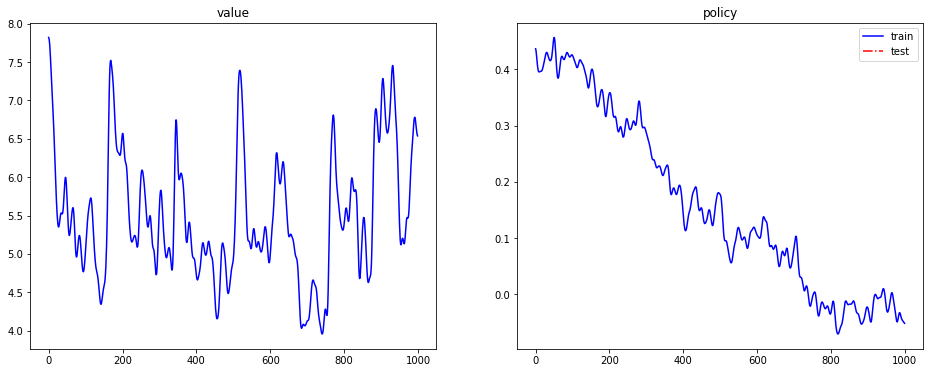

KeyboardInterrupt: 

In [38]:
step = 0
for batch in tqdm(train_dataloader):
    batch = [i.to(cuda) for i in batch]
    items, ratings, sizes = batch
    hidden = None
    state = None
    for t in tqdm(range(int(sizes.min().item()) - 1), ):
        action = items[:, t]
        reward = ratings[:, t].unsqueeze(-1)
        s = torch.cat([action, reward], 1).unsqueeze(0)
        next_state, hidden = state_encoder(s, hidden) if hidden else state_encoder(s)
        next_state = next_state.squeeze()
        if np.random.random() > 0.95 and state is not None:
            batch = [state, action, reward, next_state, torch.tensor(0)]
            loss = ddpg_update(batch, params, nets, optimizer,
                                       cuda, debugger, step=step)
            debugger.log_losses(loss)
            step += 1
            
        if step % 100 == 0 and step > 0:
            # debugger.test()
            clear_output(True)
            print(step)
            plotter.plot_loss()
        
        state = next_state


In [17]:
optimizer['policy_optimizer']

RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0.01
)